# Correlation of Correlations (Anchors Data - First Anchor Only)

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from analysis.correlation_of_correlations import *
from common.helpers import get_graphemes, get_phonemes

sns.set_style('darkgrid')

## Load Activation Data

In [3]:
anchor_probe_mapping = pd.read_pickle(f'../../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [4]:
all_data = []
for dilution in tqdm(range(1, 4)):
    anchor_list = sum(anchor_probe_mapping['anchor'].apply(lambda x: x[:1]).tolist(), [])
    # Load anchors data
    hidden_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-anchors-hidden.pkl'), 
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')])
    hidden_data['epoch'] = hidden_data['epoch'].astype(int)
    hidden_data = hidden_data[hidden_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])]
    hidden_data = hidden_data[hidden_data['orth'].isin(anchor_list)]
    hidden_data = hidden_data.drop_duplicates(subset=['epoch', 'orth'])
    
    output_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-anchors-output.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-output.pkl')])
    output_data['epoch'] = output_data['epoch'].astype(int)
    output_data = output_data[output_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])]
    output_data = output_data[output_data['orth'].isin(anchor_list)]
    output_data = output_data.drop_duplicates(subset=['epoch', 'orth'])
    
    anchors_data = pd.merge(hidden_data[['epoch', 'orth', 'hidden']], output_data, how='left', on=['epoch', 'orth']).reset_index(drop=True)
    anchors_data['dilution'] = dilution
    all_data.append(anchors_data)
    
all_data = pd.concat(all_data)
all_data = all_data.drop(columns=['target'])

100%|██████████| 3/3 [00:19<00:00,  6.39s/it]


In [5]:
# find input representations
inputs = []
for orth in all_data['orth'].unique():
    inputs.append({'orth': orth, 'input': get_graphemes(orth)})
inputs = pd.DataFrame(inputs)
all_data = all_data.merge(inputs, on='orth')

In [6]:
# find target representations
targets = []
for phon in all_data['phon'].unique():
    targets.append({'phon': phon, 'target': get_phonemes(phon)})
targets = pd.DataFrame(targets)
all_data = all_data.merge(targets, on='phon')
all_data['word_type'] = all_data['word_type'].replace({'ANC_REG': 'Regular',
                                                       'ANC_AMB': 'Ambiguous',
                                                       'ANC_EXC': 'Exception'})

## Calculate Correlation Vectors

In [7]:
regulars = all_data[all_data['word_type'] == 'Regular']
exceptions = all_data[all_data['word_type'] == 'Exception']
ambiguous = all_data[all_data['word_type'] == 'Ambiguous']

regulars = calculate_correlation_vectors(regulars)
exceptions = calculate_correlation_vectors(exceptions)
ambiguous = calculate_correlation_vectors(ambiguous)

100%|██████████| 78/78 [00:04<00:00, 16.03it/s]


## Calculate Correlation of Correlations

In [8]:
regulars = calculate_cross_layer_correlation(regulars)
exceptions = calculate_cross_layer_correlation(exceptions)
ambiguous = calculate_cross_layer_correlation(ambiguous)

In [9]:
regulars.head()

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target,input_corr_vector,hidden_corr_vector,output_corr_vector,target_corr_vector,orth_hidden_corr,hidden_phon_corr,orth_phon_corr,orth_target_corr
0,0,slit,"[0.5810385, 0.03448805, 0.7988132, 0.9942407, ...","[0.9932049, 0.9132536, 0.2636496, 0.995957, 0....",0,slit,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.34571533776594227, 0.2202970297029704,...","[1.0, 0.8576410175950273, 0.8482522054187257, ...","[1.0, 0.9364071902896003, 0.9141190556172228, ...","[1.0, 0.24601072019425108, 0.19736842105263167...",0.968270,0.893583,0.869386,0.954141
1,0,shing,"[0.7540455, 0.4483854, 0.2318757, 0.99431, 0.4...","[0.9674417, 0.9495515, 0.5947738, 0.99893, 0.2...",8,SiN,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.34571533776594227, 1.0, 0.14626418136251393...","[0.8576410175950273, 1.0, 0.8056552319202485, ...","[0.9364071902896003, 1.0, 0.9189846127239449, ...","[0.24601072019425108, 1.0, 0.24601072019425094...",0.947973,0.829250,0.837410,0.943359
2,0,krim,"[0.4121673, 0.2055272, 0.2061021, 0.9543621, 0...","[0.9885353, 0.8990538, 0.8319614, 0.9975445, 0...",3,krim,Regular,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.2202970297029704, 0.14626418136251393, 1.0,...","[0.8482522054187257, 0.8056552319202485, 1.0, ...","[0.9141190556172228, 0.9189846127239449, 1.0, ...","[0.19736842105263167, 0.24601072019425094, 1.0...",0.838395,0.765650,0.833713,0.940635
3,0,slape,"[0.4352619, 0.05554923, 0.8271431, 0.9981292, ...","[0.9936641, 0.9058637, 0.4557937, 0.9956442, 0...",9,slAp,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4227444515154856, 0.11952286093343928, -0.0...","[0.8901573412791105, 0.7544912173993167, 0.765...","[0.9668712452809385, 0.927299406478476, 0.9165...","[0.4649122807017545, -0.06024752331287778, -0....",0.903453,0.915572,0.809394,0.960408
4,0,preld,"[0.4279248, 0.1957364, 0.193935, 0.9785777, 0....","[0.9591893, 0.7856084, 0.7407619, 0.9978943, 0...",6,preld,Regular,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-0.044499415948998415, -0.05976143046671966, ...","[0.8266590758800033, 0.781721020596089, 0.9175...","[0.8987296450365369, 0.8942377011307757, 0.946...","[-0.07915594835766293, -0.0679575352774453, 0....",0.831378,0.891046,0.782132,0.979486


In [10]:
accum = []
for df in [regulars, ambiguous, exceptions]:
    for col in ['orth_hidden_corr', 'hidden_phon_corr', 'orth_phon_corr', 'orth_target_corr']:
        temp = df[['epoch', 'orth', 'word_type', 'dilution']]
        temp['corr'] = df[col]
        temp['corr_type'] = col.rstrip('_corr').replace('_', '-').title()
        accum.append(temp)
all_data = pd.concat(accum)
all_data = all_data.rename(columns={'word_type': 'type'})

In [11]:
accum = []
for row in anchor_probe_mapping['anchor'].values:
    for anchor in row:
        accum.append({'anchor': anchor, 'first_anchor': row[0]})
anchor_groups = pd.DataFrame(accum)

In [12]:
all_data = all_data.merge(anchor_groups, left_on='orth', right_on='anchor')
all_data = all_data.groupby(by=['epoch', 'dilution', 'type', 'corr_type', 'first_anchor']).mean()
all_data = all_data.reset_index(drop=False)

In [13]:
all_data.head()

,epoch,dilution,type,corr_type,first_anchor,corr
0,0,1,Ambiguous,Hidden-Phon,blome,0.939138
1,0,1,Ambiguous,Hidden-Phon,clead,0.895743
2,0,1,Ambiguous,Hidden-Phon,frow,0.869122
3,0,1,Ambiguous,Hidden-Phon,grour,0.918107
4,0,1,Ambiguous,Hidden-Phon,plone,0.902493


## Plot Results

In [14]:
HUE_ORDER = ['Regular', 'Ambiguous', 'Exception']
STYLE_ORDER = ['Orth-Hidden', 'Hidden-Phon', 'Orth-Phon', 'Orth-Target']

In [15]:
all_data = all_data[all_data['epoch'] >= 100]

### All Dilution Levels

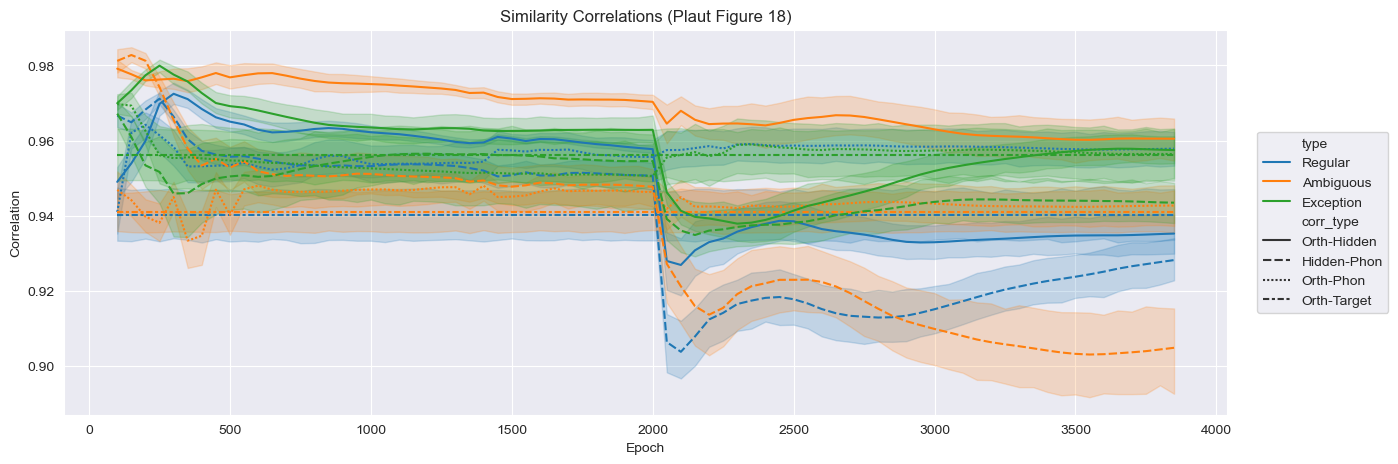

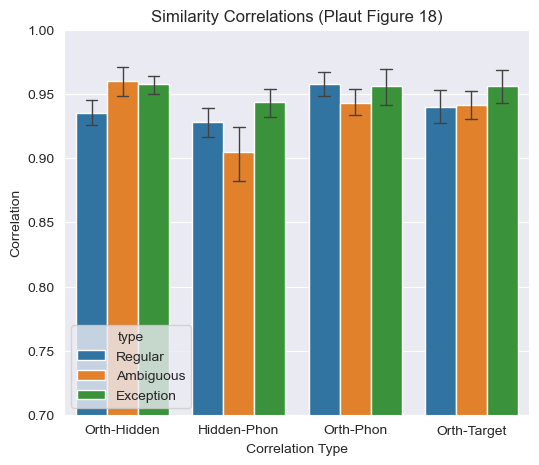

In [16]:
generate_correlation_of_correlations_lineplot(all_data, hue_order=HUE_ORDER, style_order=STYLE_ORDER)
generate_correlation_of_correlations_barplot(all_data, epoch=all_data['epoch'].max(), ylim=(0.7, 1),
                                             hue_order=HUE_ORDER, order=STYLE_ORDER)

### Individual Dilution Levels

Dilution Level: 1


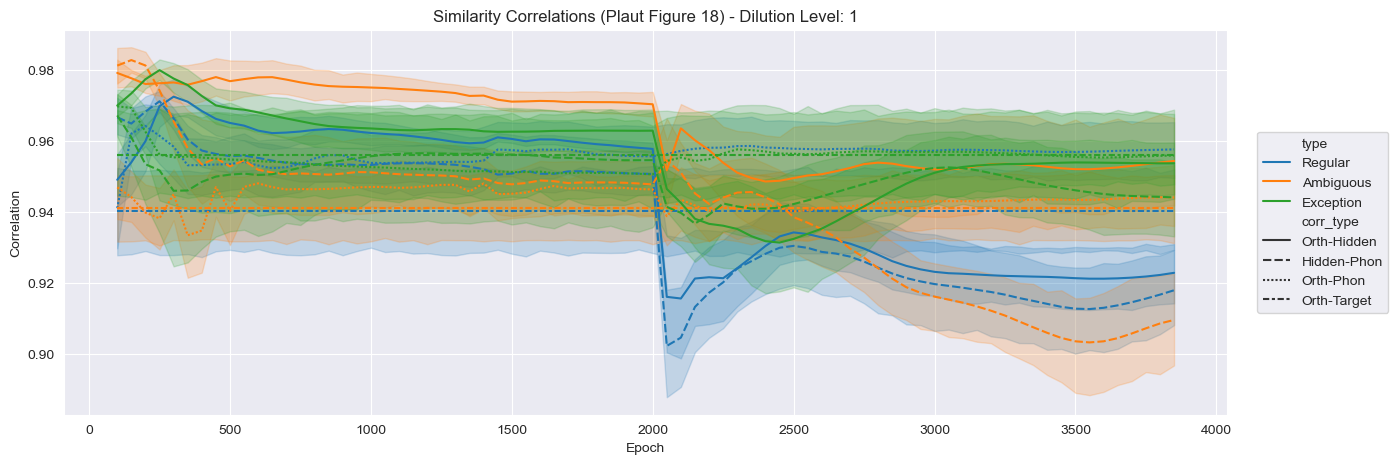

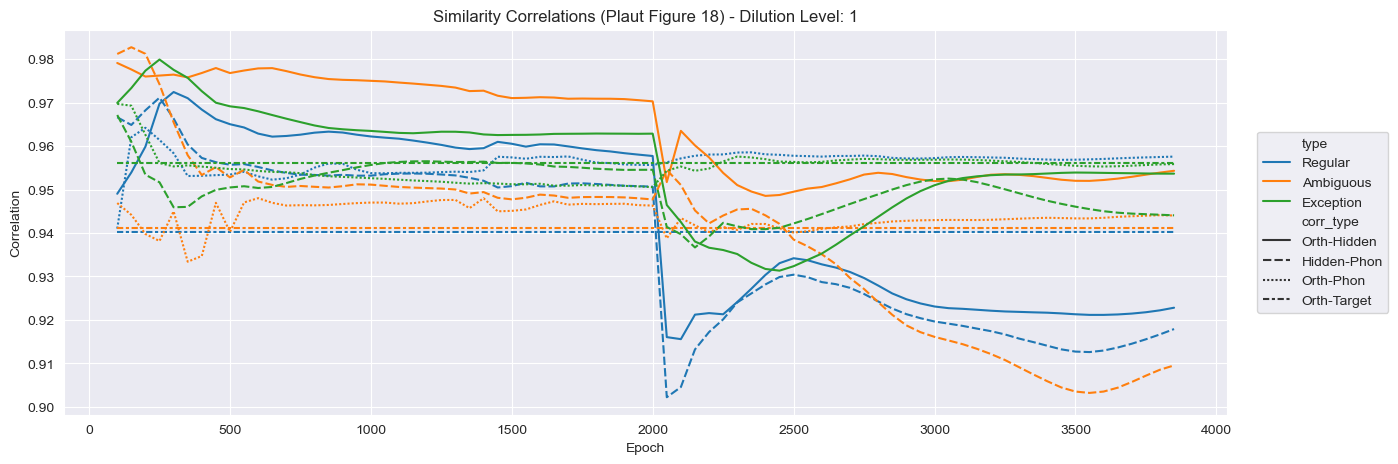

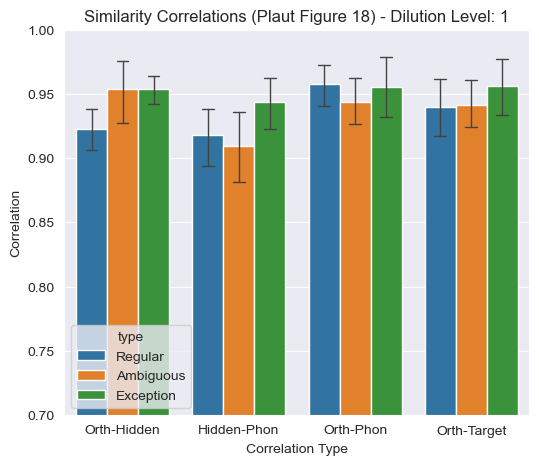

Dilution Level: 2


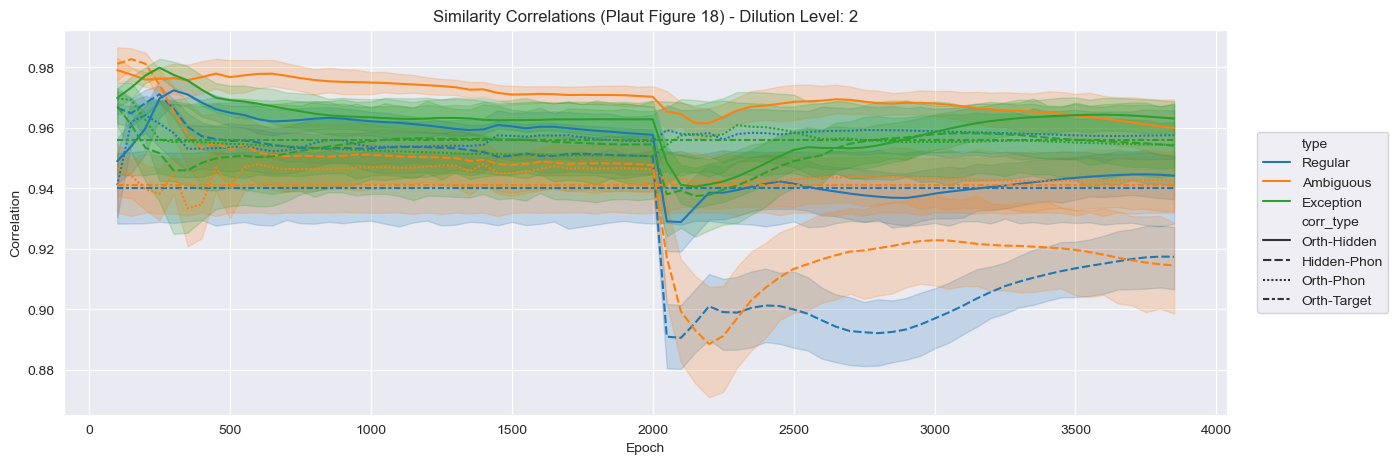

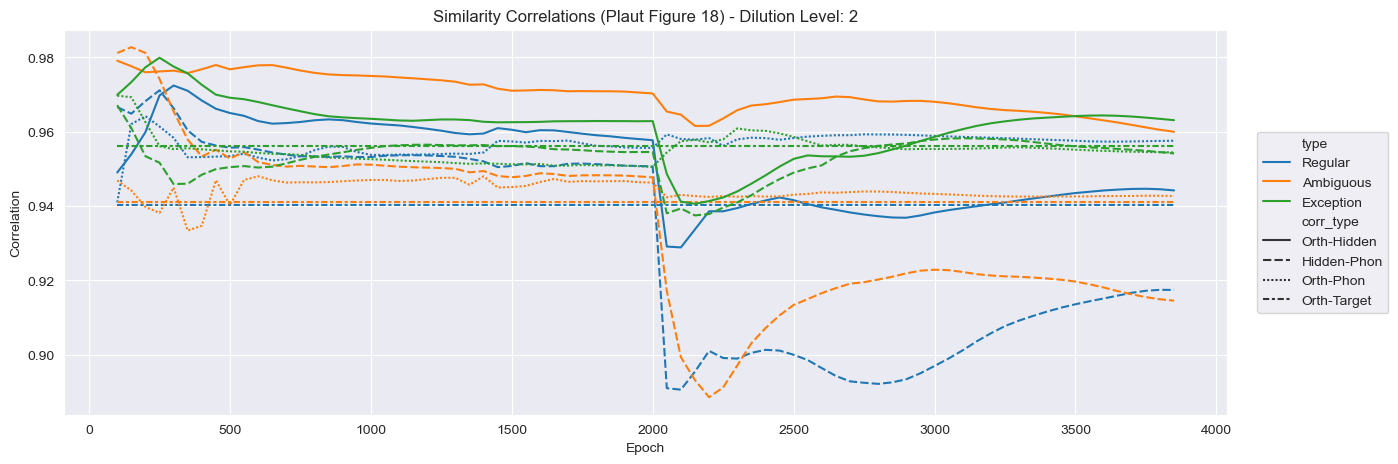

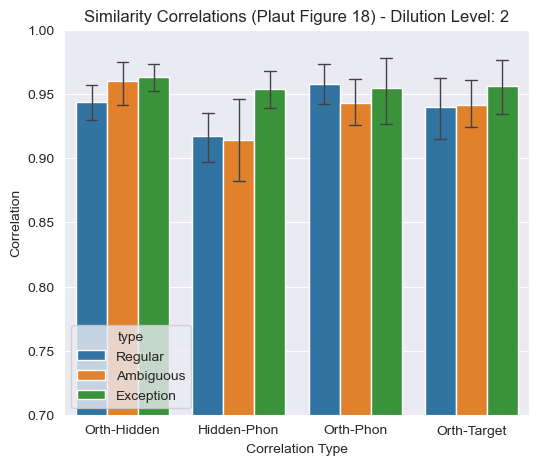

Dilution Level: 3


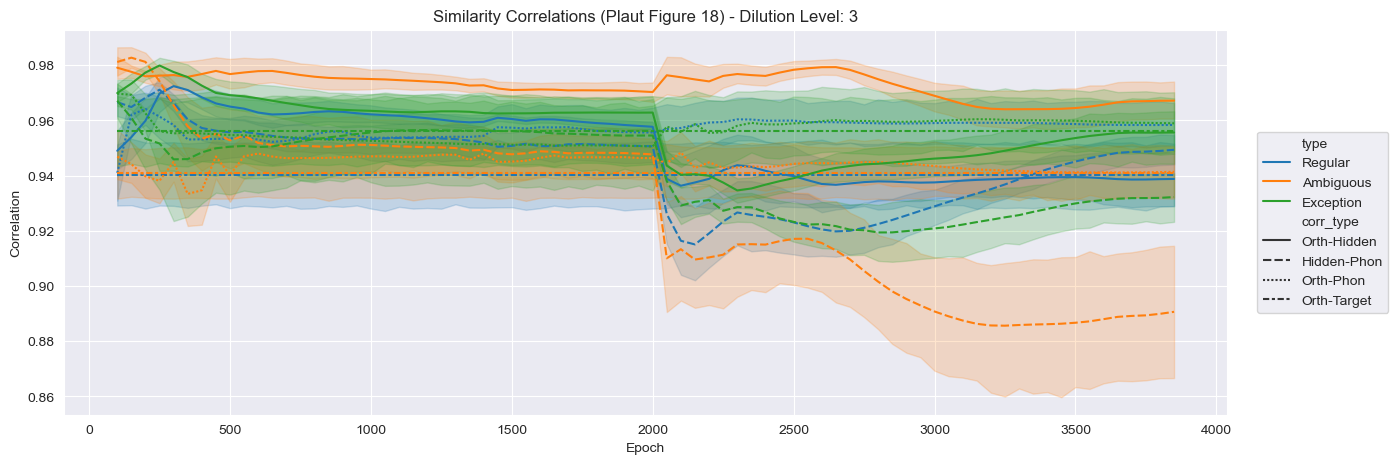

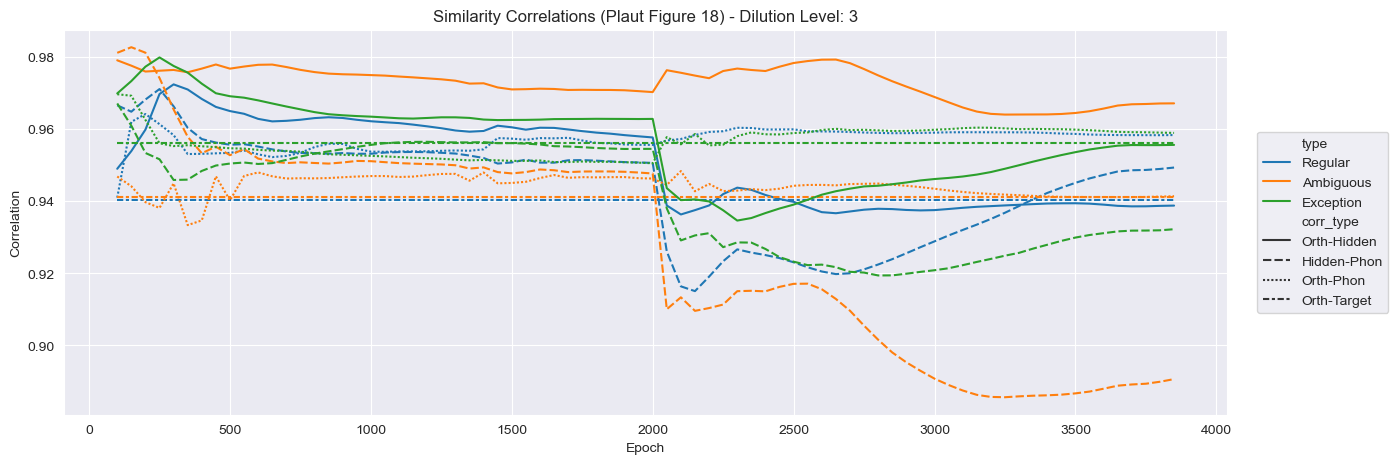

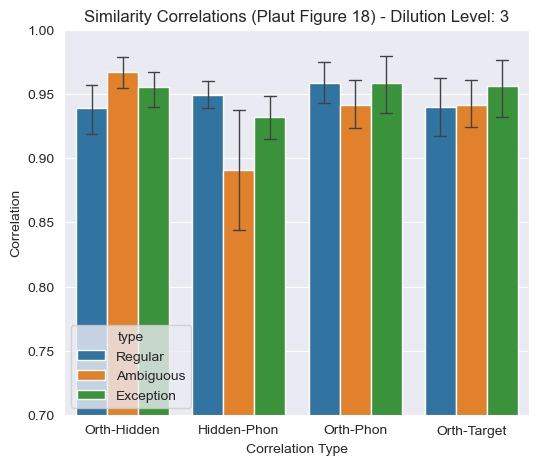

In [17]:
for dilution in range(1, 4):
    print(f'Dilution Level: {dilution}')
    generate_correlation_of_correlations_lineplot(all_data, dilution=dilution, 
                                                  hue_order=HUE_ORDER, style_order=STYLE_ORDER)
    generate_correlation_of_correlations_lineplot(all_data, dilution=dilution, error_bars=False,
                                                  hue_order=HUE_ORDER, style_order=STYLE_ORDER)
    generate_correlation_of_correlations_barplot(all_data, epoch=all_data['epoch'].max(), 
                                                 dilution=dilution, ylim=(0.7, 1), 
                                                 hue_order=HUE_ORDER, order=STYLE_ORDER)

## Checking for Outliers
I don't think there are any obvious outliers that are causing the Ambiguous correlations to be lower...

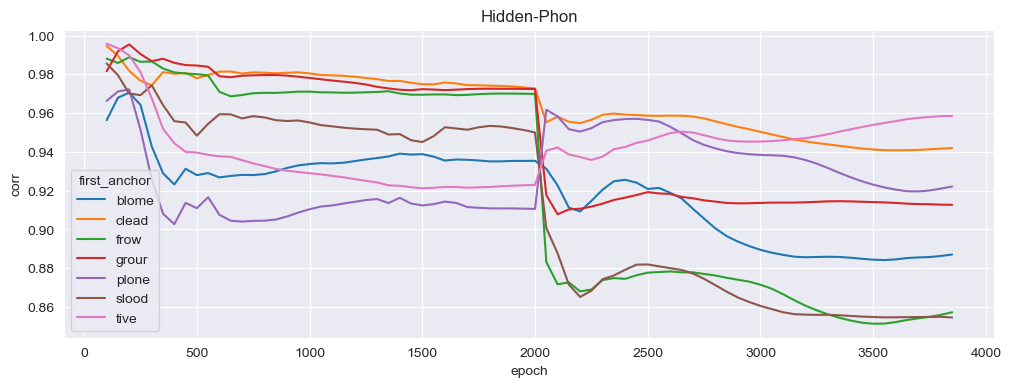

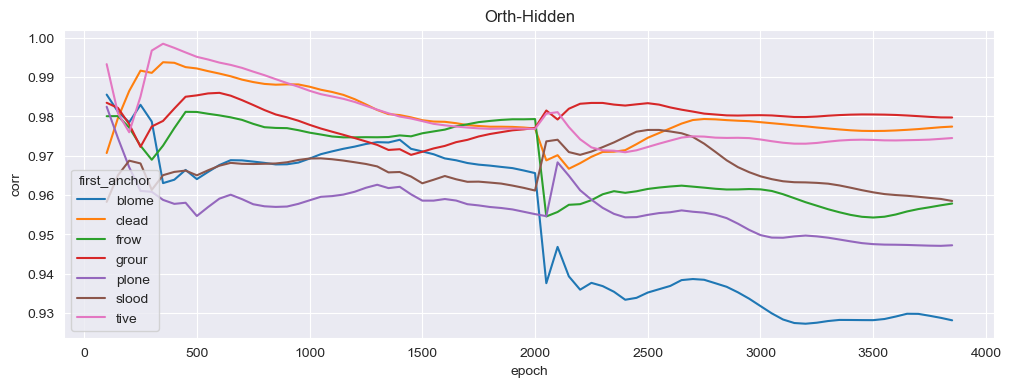

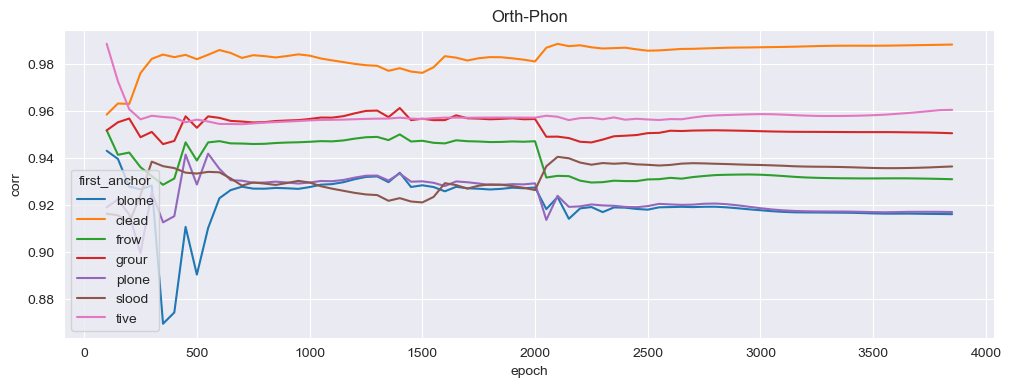

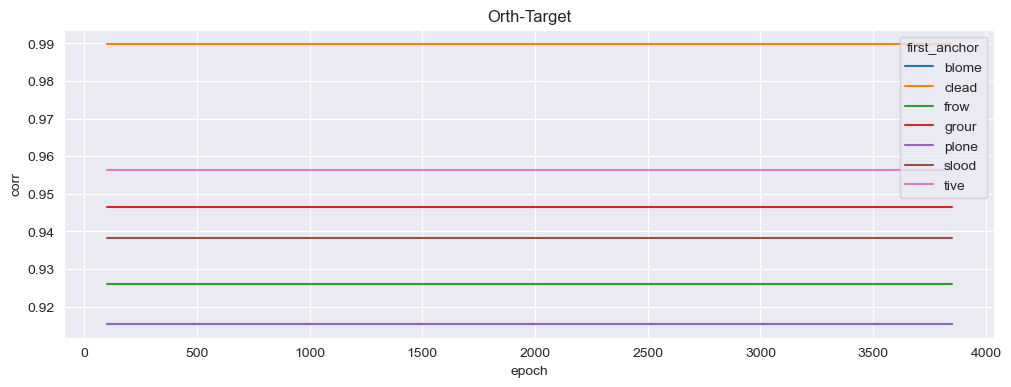

In [18]:
amb_data = all_data[all_data['type'] == 'Ambiguous']

for corr_type in amb_data['corr_type'].unique():
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=amb_data[amb_data['corr_type'] == corr_type], x='epoch', y='corr',
                 hue='first_anchor', ci=None)
    plt.title(corr_type)
    plt.show()